# Question 2. IWAL algorithm implementation (50 points)

**The purpose of this question is to implement Importance Weighted Active Learning (IWAL) algorithm. For this question, you will not use modAL, but instead will implement IWAL routine from scratch using scikit-learn, NumPy and native Python.**

**In this question, we will use a simple synthetic dataset for a binary classification problem. Each data point has only 2 features. The dataset is provided in 2 files:** 
- **`data_iwal.npy`, which contains features.**
- **`labels_iwal.npy`, which contains labels.** 

**For simplicity, you will implement bootstrapping rejection sampling subroutine with logistic regression and hinge loss.**

## Imports

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import hinge_loss, log_loss
from sklearn.linear_model import LogisticRegression
import copy

# my custom packages
from packages.iwal import iwal
from packages.iwal import loss_function as lf

## Reading data

**Here we read the data and split it into train and test datasets.**
- **Train will be used to train our classification model.**
- **Test will be used to validate the performance, monitor overfitting and compare the results of the model trained with Active Learning with the ones of the model trained from scratch. We set aside 1/3 of the dataset for validation.**

In [16]:
X = np.load("data/q2/data_iwal.npy")
y = np.load("data/q2/labels_iwal.npy")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

print(X[0:2])
print(y[0:2])

(134, 2)
(134,)
(66, 2)
(66,)
[[2.59193175 1.14706863]
 [1.7756532  1.15670278]]
[1 1]


## Part 2.1.
**Type your answers for the theoretical questions below.**

**1. What is the idea behind IWAL algorithm?**

*Machine learning is built upon the assumption that the distribution underlying the training set is the same as the distribution underlying the test set. By selecting instances using active learning, intentional sample bias is introduced - the distribution of the training set no longer matches that of the test set. This can result in inconsistent models.* 

*IWAL presents a mathematically rigorous approach for correcting for this bias, using importance weighting.*

*For every sample for which a label is requested, IWAL assigns a weight to that sample. The weight corrects for sample bias by modulating the importance of a given sample based on how likely it is for that sample to appear in the training set versus the test set.*

*IWAL calculate weights by considering the probability that the label will be requested for that sample. Generally speaking, if the version space has a lot of disagreement about the predicted label for a sample, there is a high probability that the sample will be mislabeled. In such a case, it is highly likely the label will be requested. If the version space has very little disagreement, there is a low probability the label will be requested. By inverting this probability, when we train a model on the selected samples, we correct for the fact that the training distribution will be biased toward samples with high label disagreement.*

*Using importance weighted loss, it can be shown mathematically that the error of the model learned on the training set eventually converges to the error of test set. This means that IWAL is able to use a biased training set to converge on the optimal hypothesis for the model class.*


**2. What are the assumptions made for the IWAL algorithm?**

- *IWAL assumes that samples are drawn i.i.d. from an underlying probability distribution.*
- *IWAL assumes that sampling probability is bounded away from zero. The idea that sample has some minimum chance of being labeled is required to mathematically provde that the algorithm eventually converges on the optimal hypothesis.*
- *IWAL assumes that the loss function has bounded slope asymmetry. This is to ensure that the loss functions can be normalized to \[0,1\] so sampling probability remains between 0 and 1.*

**3. What are the pros and cons of IWAL algorithm?**

*The pros:*
- *IWAL can be used for multiclass classifiers (as well as binary).*
- *IWAL allows for the use of a generalized loss function (i.e. it does not require us to use 0-1 loss), making it useable for problems in which other loss functions are more appropriate.*
- *IWAL has rigorous generalization bounds, with upper bounds over the number of labels requested and lower bounds over label complexity. The algorithm has similar performance to standard supervised learning in terms of sample complexity.*
- *IWAL does not require explicit enumeration over the hypothesis class.*
- *IWAL handles non-separable data.*
- *IWAL can be used with any data access model.*

*The cons:*
- *Variance can be difficult to control, leading to different outcomes depending on the samples seen.*
- *The hypothesis chosen by IWAL is only guaranteed to converge on the optimal model in the long-run. Given a finite number of samples, it is possible that the model does not perform as well as optimal hypothesis in the class.*
- *The number of samples required by IWAL to arrive at the optimal model is bounded, but it is possible that the number required exceeds the sample budget.*

***

For my own understanding.

### What is hinge loss?
Hinge loss is a loss function which can be used as the objective for training SVM and logistic regression models. Unlike 0-1 loss, hinge loss is convex and can be used in convex optimization.


### How does hinge loss work?
This section references the following [source](https://www.coursera.org/lecture/machine-learning-classification-algorithms/hinge-loss-6Dm8n). 

#### 0-1 Loss

Let's start with how 0-1 loss works, because it is helpful to contrast the two. 0-1 loss, or missclassification loss, is defined as follows for a binary classification problem where $y_i, \hat{y}_i \in -1, +1$:

$$l_{misclassification}(\hat{y}_i,y_i)=\begin{cases}
1, && \text{if } y_i\hat{y}_i=-1\\
0, && \text{otherwise }
\end{cases}$$

This loss function is discontinuous, so it is not convex and gradient methods of optimization such as the one used with logistic regression cannot be applied. Additionally, this loss function treats every misclassification as equally bad. 


#### Hinge-loss
Assume we want to penalize some misclassifications more than others. We want stronger penalties for misclassified samples further from the decision boundary. 

Consider how the decision boundary is defined for SVM:

$\hat{z}_i=x_i^Tw=0$

$\hat{z}$ represents the signed distance from the decision boundary (which is then used inside `sign()` to determine the class). We can create a penalty based on $\hat{z}$:

$y\hat{z}$

- big positive: deeply on wrong side
- big negative: deeply on correct side

$-y\hat{z}$

- big positive: deeply on correct side
- big negative: deeply on wrong side

We also want to create a margin for error so that correctly classified samples which are close to the decision boundary are also given a small penalty (encouraging the boundary to be positioned further from points). Margin is conventionally set as 1, so we get:

$1-y\hat{z}$

- big positive: deeply on correct side
- big negative: deeply on wrong side

However, this function would also result in negative loss for all correctly classified points outside the margin. This is the only scenario in which we get negative values with this loss function, so we can filter out losses less than zero. The result is hinge loss:

$$l_{hinge}=max\{0,1-y\hat{z}\}$$

- $0$: correctly labeled, outside margin
- $1-y\hat{z}$: otherwise, with larger values further from decision boundary


This gives us what we want, and it also results in a convex function which can be used for gradient optimization.



#### Visual Comparison

![image.png](img/0-1_loss_vs_hinge_loss.png)






### Why use hinge loss with IWAL?
IWAL works with any loss function that can be bounded \[0,1\]. We use in this implementation because we are using Logistic Regression models for both bootstrapping predictors and the final predictor trained by IWAL, and a commonly used loss function for logistic regression is hinge loss.

If asked, "Why use hinge loss instead of log loss?", one answer according to [this](https://stats.stackexchange.com/questions/146277/hinge-loss-vs-logistic-loss-advantages-and-disadvantages-limitations#:~:text=Logarithmic%20loss%20minimization%20leads%20to,t%20help%20at%20probability%20estimation.&text=Hinge%20loss%20leads%20to%20better,much%20less%20sensitivity%20regarding%20probabilities) source is that hinge loss punishes misclassifications more than log loss, which can be useful for determining margins. We care most about the loss difference between predictors, so this seems appropriate.

The authors of the IWAL paper mention different loss functions, and hinge loss is one of these.

## Part 2.2 Implement IWAL algorithm
**In this part you will implement a function that performs a single query of Algorithm 1 IWAL (subroutine rejection-sampling) from the paper.** 

In [17]:
# implemented as module iwal in custom Python package iwal

## Part 2.3. Implement bootstrapping rejection sampling subroutine
**In this part you will implement bootstrapping rejection sampling subroutine from the paper, section 7.2.**

In [18]:
# # implemented as modules rejection_threshold and loss_function in custom Python package iwal

## Part 2.4. Organize all implemented parts into a single pipeline
**You implemented all parts of the IWAL algorithm with bootstrap rejection sampling. Now organize it into a pipeline.**

### 2.4. Run pipeline

In [31]:
%%time

# copy data for use with this section
X_train_iwal = copy.deepcopy(X_train)
y_train_iwal = copy.deepcopy(y_train)


# additional arguments
history = {}
selected = {}
rejection_threshold = 'bootstrap'
loss_function = lf.normalized_hinge_loss_2  # approx the same results as hinge_loss_2 and hinge_loss_3


# Perform queries and record loss
losses_AL = []
n_query = 60  # first 10 queries are bootstrapping process
for t in range(n_query):
    
    # select sample at random
    idx = np.random.choice(X_train_iwal.shape[0], 1, replace=False)
    x_t = X_train_iwal[idx].reshape(2,)  # shape expected by function
    y_t = y_train_iwal[idx].reshape(1,)  # shape expected by function
    
    # remove sample from stream
    X_train_iwal, y_train_iwal = np.delete(X_train_iwal, idx, axis=0), np.delete(y_train_iwal, idx, axis=0)

    # select optimal hypothesis
    h_t = iwal.iwal_query(x_t,y_t,history,selected,rejection_threshold, loss_function)

    # calculate loss only for fitted models
    if t >= 10 and h_t:
        loss_t = log_loss(y_test, h_t.predict_proba(X_test)) 
        losses_AL.append(loss_t)
     

CPU times: user 8.07 s, sys: 56.8 ms, total: 8.13 s
Wall time: 8.16 s


### 2.4. Plot results

In [77]:
def plot_loss(losses):
    plt.xlabel('Number of queries')
    plt.ylabel('Loss')
    plt.title('Number of queries vs Loss')
    plt.plot(losses)
    plt.show()

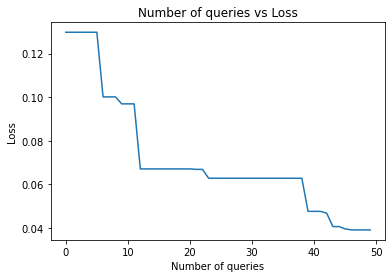

In [78]:
plot_loss(losses_AL)

## Part 2.5. Compare results of Active Learning vs Offline Learning
**In this part you need to create object of the same scikit learning class and train it on randomly selected subset of data points and compare results of 2 classifiers. Comment on your observations.**

### 2.5. Run Pipeline

In [71]:
# copy data for use with this section
X_train_OFF = copy.deepcopy(X_train)
y_train_OFF = copy.deepcopy(y_train)

losses_OFF = []
lr = LogisticRegression()

# consider performance of model as more and more samples are added
for t in range(10,135):
    
    # select sample at random
    idx = np.random.choice(X_train_OFF.shape[0], t, replace=False)
    x_t = X_train_OFF[:t]
    y_t = y_train_OFF[:t]

    # train model
    lr.fit(x_t, y_t)
    loss = log_loss(y_test, lr.predict_proba(X_test))
    losses_OFF.append(loss)

### 2.5. Plot Results

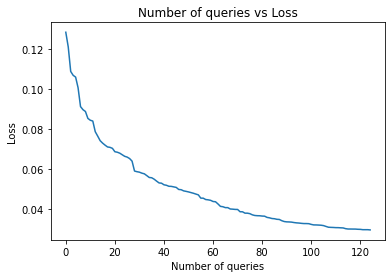

In [79]:
plot_loss(losses_OFF)

### 2.5. Compare Results

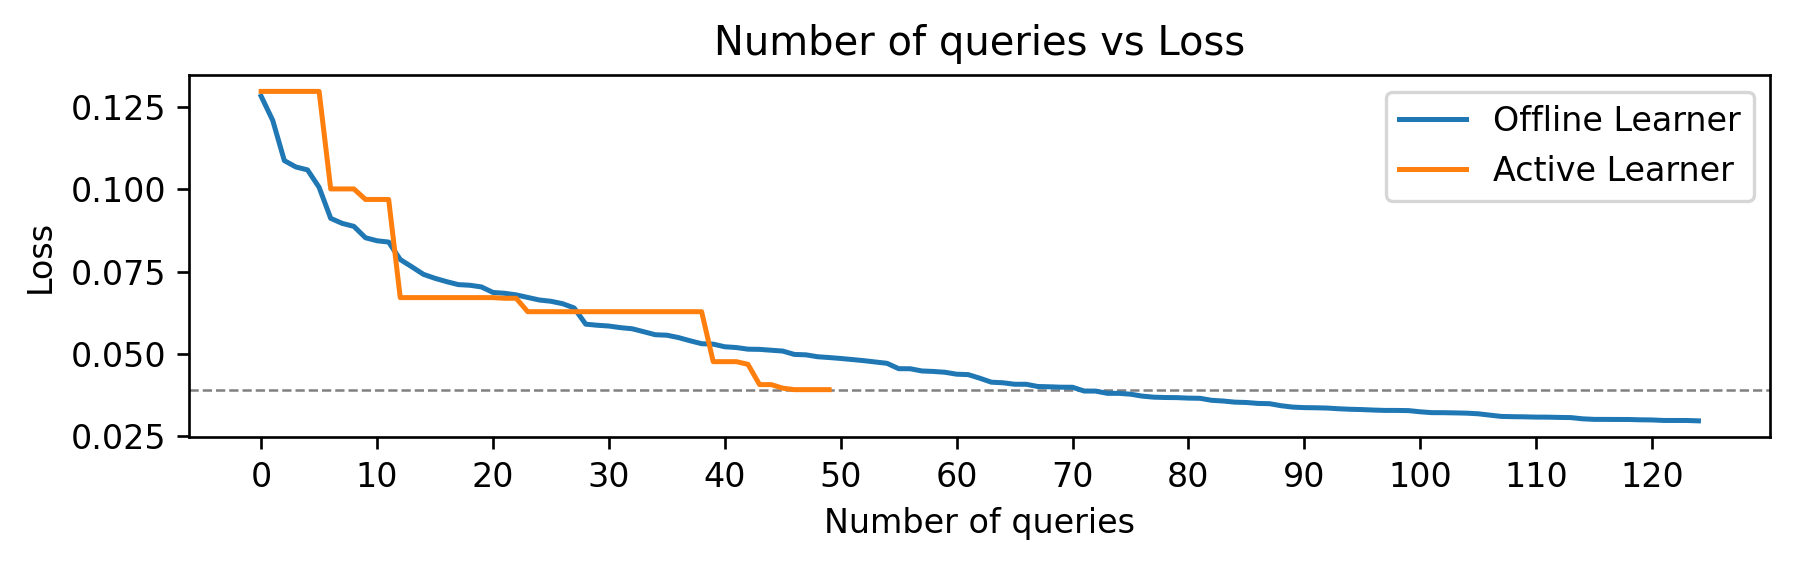

In [73]:
# plot both together
fig, ax = plt.subplots(figsize=(8.5, 2), dpi=240)
ax.axhline(y=min(losses_AL),linestyle='--',linewidth='0.75',color='grey')
ax.plot(losses_OFF, label='Offline Learner')
ax.plot(losses_AL,label='Active Learner')
plt.xlabel('Number of queries')
plt.ylabel('Loss')
plt.title('Number of queries vs Loss')
plt.xticks(range(0, 130,10))
plt.legend()
plt.show()

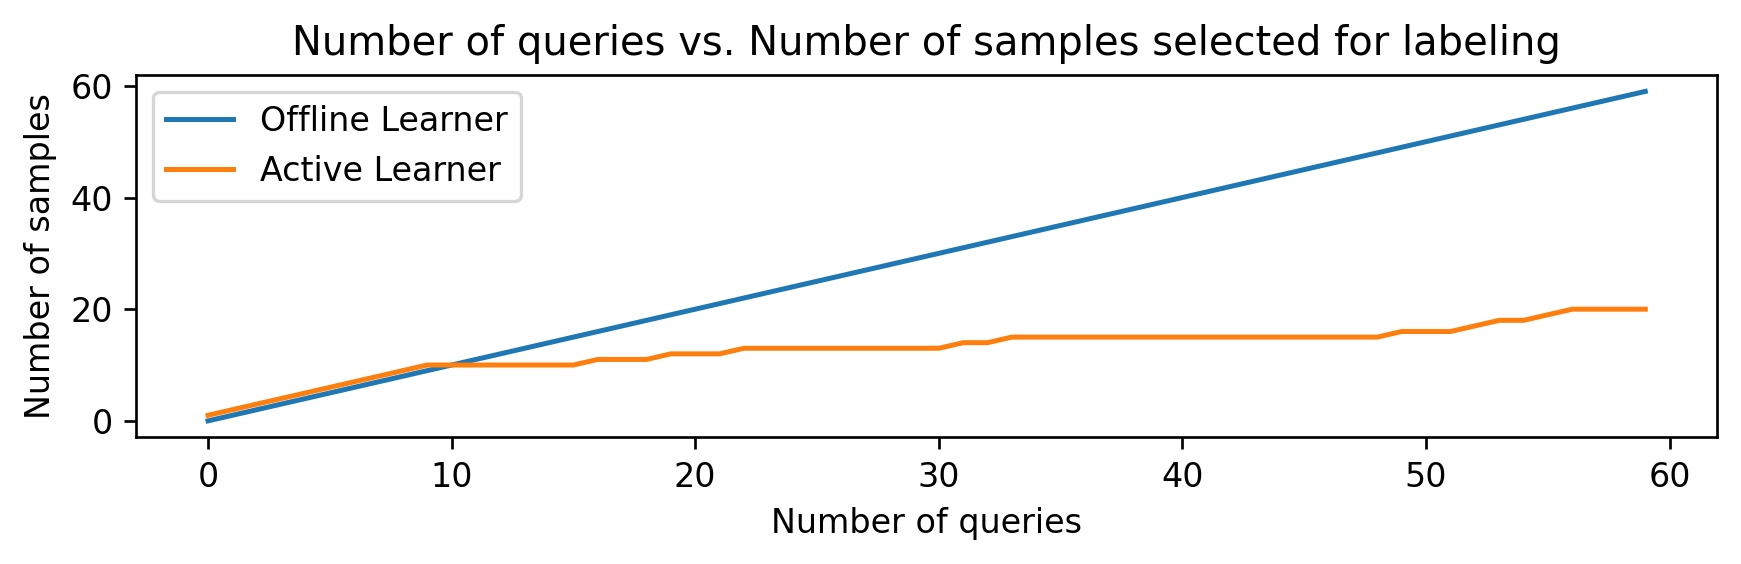

In [80]:
# compare number of samples selected over runtime by each learner
num_selected_OFF = [ i for i in range(60)]
num_selected_AL = []

total = 0
for t in range(60):
    if history['Q'][t] == 1:
        total += 1
    num_selected_AL.append(total)
        
# plot both together
fig, ax = plt.subplots(figsize=(8.5, 2), dpi=240)
ax.plot(num_selected_OFF, label='Offline Learner')
ax.plot(num_selected_AL,label='Active Learner')
plt.xlabel('Number of queries')
plt.ylabel('Number of samples')
plt.title('Number of queries vs. Number of samples selected for labeling')
plt.legend()       
plt.show()

In [83]:
# count number of samples used to train active learner vs offline learner to the same performance

# active learner
count_AL = 0
for each in history['Q']:
    if each == 1:
        count_AL += 1

# best performance active learner
min_loss_AL = min(losses_AL)


count_OFF = 10
for loss in losses_OFF:
    if loss > min_loss_AL:
        count_OFF += 1
        

# compare performance
print('Minimum loss, Active Learner:', min_loss_AL)
print('Minimum loss, Offline Learner:',min(losses_OFF))

print('Number of samples used to train active learner:',count_AL)
print('Number of samples used to train offline learner to the same accuracy:', count_OFF)

Minimum loss, Active Learner: 0.03903947015682811
Minimum loss, Offline Learner: 0.02953955329461491
Number of samples used to train active learner: 20
Number of samples used to train offline learner to the same accuracy: 81


### 2.5. Comment on observations
*The active learner was able to achieve similar levels of performance to the offline learner while using a much smaller set of samples.* 

*This makes sense. The labeling of instances from the disagreement region is more likely to improve the model than labeling a random instance. By eliminating hypotheses which are the least consistent with the labeled data, the more likely it is that the remaining hypotheses are able to generalize. With IWAL, a sample has higher probability of being labeled if there is more disagreement about the predicted label. This bias means samples selected by IWAL are more likely to improve the model than samples selected at random. The result is that IWAL can more quickly achieve higher levels of performance than an offline learning selecting samples at random.*